In [128]:
#pip3 install numpy pandas scikit-learn tensorflow torch transformers spacy
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, TimeDistributed, Masking
from tensorflow.keras.models import Sequential

In [129]:
#!pip3 install chardet
#!pip3 install datasets

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

### Named Entity Recognition (NER) ###
NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

B - {CHUNK_TYPE} – for the word in the Beginning chunk
I - {CHUNK_TYPE} – for words Inside the chunk
O – Outside any chunk
The IOB tags are further classified into the following classes –

geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon


prep train data

In [131]:
import os
import chardet
import json
def detect_file_encoding(file_path):
    """Detect the encoding of a file."""
    with open(file_path, 'rb') as f:  # Open in binary mode
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

def prepare_hf_dataset(parent_folder):
    """Prepare the dataset from all year folders in the given parent folder."""
    dataset = {"tokens": [], "tags": []}
    
    # Iterate over all year folders in the parent folder
    for year_folder in os.listdir(parent_folder):
        year_path = os.path.join(parent_folder, year_folder)
        if os.path.isdir(year_path):  # Check if it's a folder
            for file in os.listdir(year_path):
                if file.endswith(".final"):
                    file_path = os.path.join(year_path, file)
                    # print(f"Processing file: {file_path}")  # Debugging
                    
                    # Detect encoding
                    try:
                        encoding = detect_file_encoding(file_path)
                        # print(f"Detected encoding for {file_path}: {encoding}")
                        with open(file_path, 'r', encoding=encoding) as f:
                            tokens, tags = [], []
                            for line in f:
                                if line.strip():  # Non-empty line
                                    parts = line.strip().split()
                                    if len(parts) == 2:
                                        word, tag = parts
                                        tokens.append(word)
                                        tags.append(tag)
                                else:  # Empty line signals end of a sentence
                                    if tokens and tags:
                                        dataset["tokens"].append(tokens)
                                        dataset["tags"].append(tags)
                                        tokens, tags = [], []  # Reset for next sentence
                            # Ensure the last sentence in the file is added
                            if tokens and tags:
                                dataset["tokens"].append(tokens)
                                dataset["tags"].append(tags)
                    except UnicodeDecodeError as e:
                        print(f"Error processing file {file_path}: {e}")
    
    return dataset

# Test the function
dataset_dir = os.getcwd() + "/Combine_Dataset"
dataset = dict({})

for dir in os.scandir(dataset_dir):
    if dir.is_dir():
        try:
            # Attempt to prepare the dataset for this directory
            dataset[dir.name] = prepare_hf_dataset(f"{dataset_dir}/{str(dir.name)}")
            
            # Save the dataset to a JSON file
            output_file = f"{dir.name}_dataset.json"
            with open(output_file, 'w', encoding='utf-8', errors='replace') as f:
                json.dump(dataset[dir.name], f)
            print(f"Dataset saved to {output_file}")
        
        except UnicodeDecodeError as e:
            print(f"Skipping directory {dir.name} due to encoding issue: {e}")
        except Exception as e:
            print(f"An error occurred with directory {dir.name}: {e}")

Error processing file c:\Users\Cs-Store\Desktop\lterm\NLP\NLP-NER/Combine_Dataset/dev\2012\2012-38-4-867-915.final: 'charmap' codec can't decode byte 0x81 in position 1579: character maps to <undefined>
Dataset saved to dev_dataset.json
Dataset saved to test_dataset.json
Error processing file c:\Users\Cs-Store\Desktop\lterm\NLP\NLP-NER/Combine_Dataset/train\2012\2012-38-2-223-260.final: 'charmap' codec can't decode byte 0x81 in position 334: character maps to <undefined>
Error processing file c:\Users\Cs-Store\Desktop\lterm\NLP\NLP-NER/Combine_Dataset/train\2021\2021-47-2-445-476.final: 'charmap' codec can't decode byte 0x9d in position 384: character maps to <undefined>
Dataset saved to train_dataset.json


In [132]:
import pandas as pd
train_df = pd.read_json("train_dataset.json")
test_df = pd.read_json("test_dataset.json")
dev_df = pd.read_json("dev_dataset.json")

print(f"Train Size: {len(train_df)}")
print(f"Test Size: {len(test_df)}")
print(f"Dev Size: {len(dev_df)}")

def labels_lower_to_upper(df):
    for i, tags in enumerate(df.tags):
        for tag in tags:
            if tag.islower():
                df['tags'][i][tags.index(tag)] = tag.upper()

labels_lower_to_upper(train_df)
labels_lower_to_upper(test_df)
labels_lower_to_upper(dev_df)

Train Size: 502
Test Size: 60
Dev Size: 48


In [133]:
def clean_labels(df):
    for i, tags in enumerate(df.tags):
        for tag in tags:
            if tag.islower():
                df['tags'][i][tags.index(tag)] = tag.upper()
            if len(tag) > 1:
                df['tags'][i][tags.index(tag)] = tag[0]
            if tag=='0':
                df['tags'][i][tags.index(tag)] = 'O'
    
clean_labels(train_df)
clean_labels(test_df)
clean_labels(dev_df)

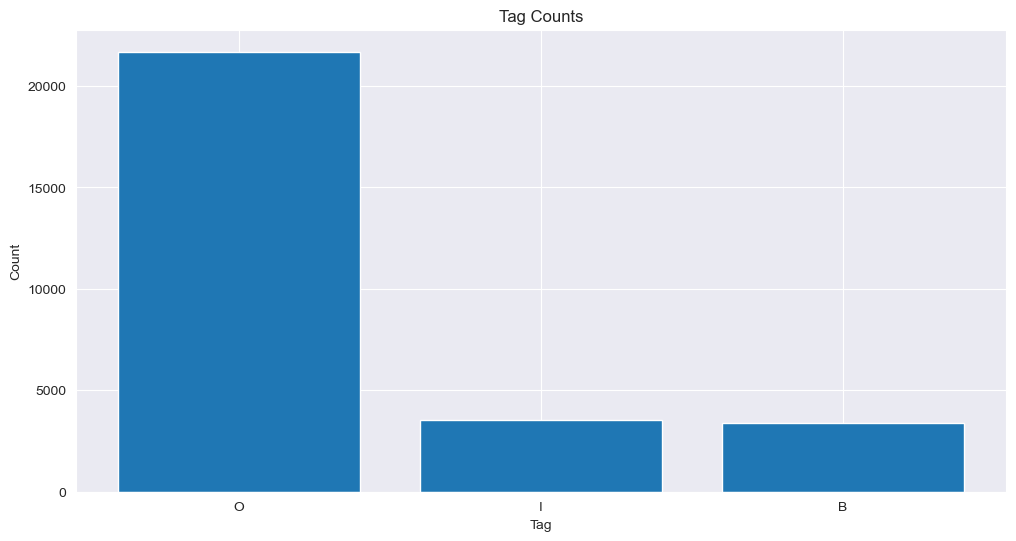

In [134]:
#plot the tags
import matplotlib.pyplot as plt
import numpy

# Count the number of occurrences of each tag
tag_counts = {}
for tags in train_df["tags"]:
    for tag in tags:
        if tag not in tag_counts:
            tag_counts[tag] = 0
        tag_counts[tag] += 1
        
# Sort the tags by count
sorted_tag_counts = dict(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the tag counts
plt.figure(figsize=(12, 6))
plt.bar(sorted_tag_counts.keys(), sorted_tag_counts.values())
# plt.xticks(rotation=45)
plt.xlabel("Tag")
plt.ylabel("Count")
plt.title("Tag Counts")
plt.show()

In [135]:
# Convert the data into a Hugging Face dataset
from datasets import Dataset
dev_hugging_face_dat = Dataset.from_dict({
    "tokens": dev_df["tokens"],
    "tags": dev_df["tags"]
})

train_hugging_face_dat = Dataset.from_dict({
    "tokens": train_df["tokens"],
    "tags": train_df["tags"]
})

test_hugging_face_dat = Dataset.from_dict({
    "tokens": test_df["tokens"],
    "tags": test_df["tags"]
})

In [136]:
def extract_features(tokens, idx):
    word = tokens[idx]
    features = {
        'word': word,  # Current word
        'is_upper': word.isupper(),  # Is the word uppercase?
        'is_title': word.istitle(),  # Is the word title case?
        'is_digit': word.isdigit(),  # Is the word a digit?
        'word_len': len(word),  # Length of the word
    }
    
    # Previous word features
    if idx > 0:
        features['prev_word'] = tokens[idx - 1]
    else:
        features['prev_word'] = "<START>"
    
    # Next word features
    if idx < len(tokens) - 1:
        features['next_word'] = tokens[idx + 1]
    else:
        features['next_word'] = "<END>"
    
    return features

def prepare_data_for_crf(dataset):
    features = []
    labels = []
    
    for example in dataset:
        tokens = example['tokens']
        tags = example['tags']
        
        # Extract features for each token
        sentence_features = [extract_features(tokens, idx) for idx in range(len(tokens))]
        features.append(sentence_features)
        labels.append(tags)
    
    return features, labels


In [137]:
# Example: Assuming train_dataset is the Hugging Face dataset
train_features, train_labels = prepare_data_for_crf(train_hugging_face_dat)
test_features, test_labels = prepare_data_for_crf(test_hugging_face_dat)


In [138]:

tags=train_df['tags']
tokens=train_df['tokens']

In [139]:
import pandas as pd

def create_sentence_word_tag_pairs(tags_df, tokens_df):
  sentences = []
  for i in range(len(tags_df)):
    tag_list = tags_df.iloc[i]
    token_list = tokens_df.iloc[i]
    sentence = list(zip(token_list, tag_list))
    sentences.append(sentence)
  return sentences

# Assuming your data is in pandas DataFrames named 'tags' and 'tokens'
# Replace 'tags' and 'tokens' with the actual names of your DataFrames

# Create the list of sentences
sentences = create_sentence_word_tag_pairs(tags, tokens)

print(sentences[:2])  # Print the first two sentences

[[('In', 'O'), ('this', 'O'), ('article', 'O'), ('we', 'O'), ('discuss', 'O'), ('several', 'O'), ('metrics', 'B'), ('of', 'I'), ('coherence', 'I'), ('defined', 'O'), ('using', 'O'), ('centering', 'B'), ('theory', 'I'), ('and', 'O'), ('investigate', 'O'), ('the', 'O'), ('usefulness', 'O'), ('of', 'O'), ('such', 'O'), ('metrics', 'B'), ('for', 'O'), ('information', 'O'), ('ordering', 'O'), ('in', 'O'), ('automatic', 'B'), ('text', 'I'), ('generation', 'I'), ('.', 'O')], [('We', 'O'), ('estimate', 'O'), ('empirically', 'O'), ('which', 'O'), ('is', 'O'), ('the', 'O'), ('most', 'O'), ('promising', 'O'), ('metric', 'B'), ('and', 'O'), ('how', 'O'), ('useful', 'O'), ('this', 'O'), ('metric', 'B'), ('is', 'O'), ('using', 'O'), ('a', 'O'), ('general', 'O'), ('methodology', 'O'), ('applied', 'O'), ('on', 'O'), ('several', 'O'), ('corpora', 'B'), ('.', 'O')]]


In [140]:
import pandas as pd

def extract_words_from_dataframe(df):
  all_words = []
  for sentence in df['tokens']:  # Assuming the column name is 'tokens'
    all_words.extend(sentence)
  return all_words

# Assuming your DataFrame is named 'df'
word = extract_words_from_dataframe(train_df) 
print(word)

['In', 'this', 'article', 'we', 'discuss', 'several', 'metrics', 'of', 'coherence', 'defined', 'using', 'centering', 'theory', 'and', 'investigate', 'the', 'usefulness', 'of', 'such', 'metrics', 'for', 'information', 'ordering', 'in', 'automatic', 'text', 'generation', '.', 'We', 'estimate', 'empirically', 'which', 'is', 'the', 'most', 'promising', 'metric', 'and', 'how', 'useful', 'this', 'metric', 'is', 'using', 'a', 'general', 'methodology', 'applied', 'on', 'several', 'corpora', '.', 'Our', 'main', 'result', 'is', 'that', 'the', 'simplest', 'metric', '(', 'which', 'relies', 'exclusively', 'on', 'NOCB', 'transitions', ')', 'sets', 'a', 'robust', 'baseline', 'that', 'cannot', 'be', 'outperformed', 'by', 'other', 'metrics', 'which', 'make', 'use', 'of', 'additional', 'centering', 'based', 'features', '.', 'This', 'baseline', 'can', 'be', 'used', 'for', 'the', 'development', 'of', 'both', 'text', 'to', 'text', 'and', 'concept', 'to', 'text', 'generation', 'systems', 'Current', 'machine

In [141]:
import pandas as pd

def extract_words_from_dataframe(df):
  all_words = []
  for sentence in df['tokens']:  # Assuming the column name is 'tokens'
    all_words.extend(sentence)
  return all_words

def find_unique_words(words):
  return list(set(words))

# Assuming your DataFrame is named 'train_df'
all_words = extract_words_from_dataframe(train_df) 
unique_words = find_unique_words(all_words)

print(unique_words)

['arrangement', 'its', 'just', 'BabelNet', 'languages', 'emerges', 'foundation', 'would', 'nps', 'then', 'examples', 'deciphering', 'classical', 'surrounding', 'Markus', 'deemed', 'Treebank', 'Annotation', 'formalization', 'centering', 'String', 'classes', 'walks', 'disambiguates', 'choices', 'uncertain', 'binary', 'Microsoft', 'crowd', 'enriched', 'here', 'explainability', 'release', 'express', 'differences', 'tensor', 'centered', '40', 'percentages', 'We', 'Bikel', 'expectation', 'mix', 'Hole', 'morphosyntactic', 'intensifies', 'subsumes', 'Just', 'shown', 'appear', 'large-scale', 'Broadcast', 'exact', 'Thot', 'treating', 'long', 'leading', 'People', 'political', 'M.', 'Knowing', 'programming', 'CoNLL', 'prevalent', 'boundary', 'vertex', 'corpus', 'constitute', 'publicly', 'very', 'native', 'eXtended', 'furthermore', 'LA', 'performance', 'humans', 'Appraisals', 'remarkable', 'individual', 'international', 'factor', 'speak', 'promises', 'minimal', 'still', 'number', 'comes', 'historic

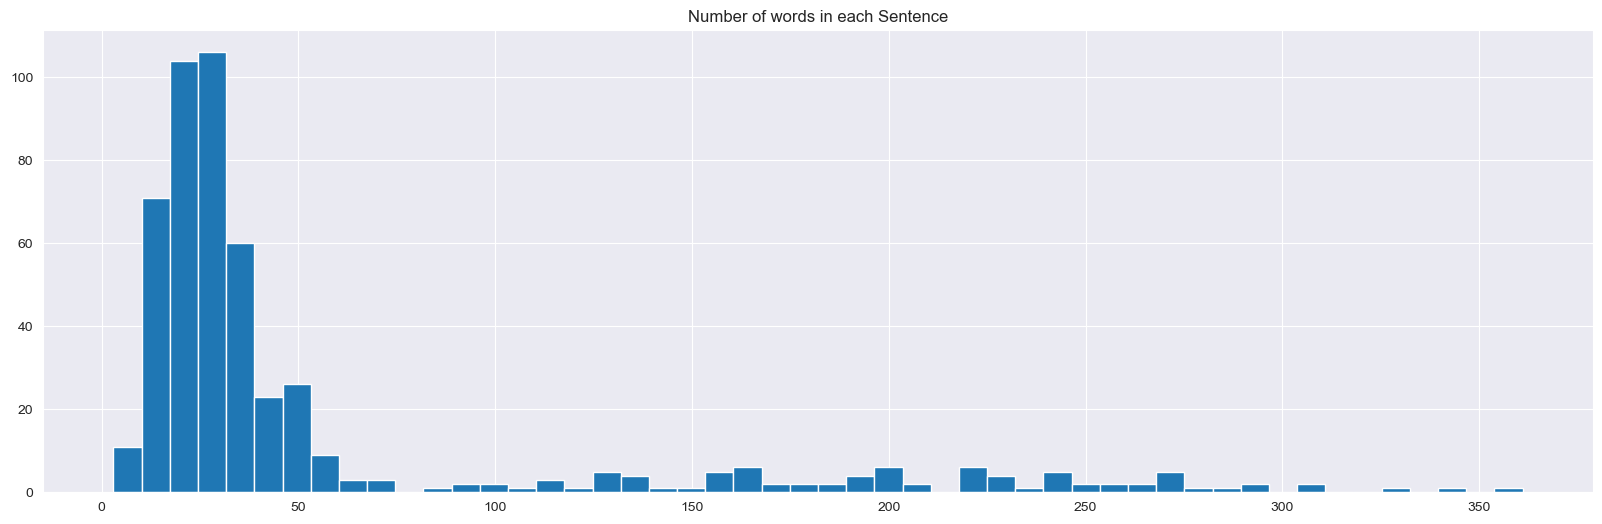

Number of Sentences: 502
Maximum sequence length: 361
Number of unique words: 4002


In [142]:
import matplotlib.pyplot as plt

# Assuming 'sentences' is a list of sentences (where each sentence is a list of words)

# Plot the distribution of sentence lengths
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')
plt.show()

# Find the maximum sentence length
maxlen = max([len(s) for s in sentences])

# Print the number of sentences and maximum sequence length
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

# Add a special token for padding
word.append("ENDPAD") 

# Calculate the number of unique words
n_words = len(unique_words)
print('Number of unique words:', n_words)

In [143]:
unique_tags = list(set(tag for tags in train_labels for tag in tags))


In [144]:
tags=(unique_tags)
words=(unique_words)

In [145]:
data = pd.read_json("train_dataset.json")
print(data.shape)
data.head()

(502, 2)


,tokens,tags
0,"[In, this, article, we, discuss, several, metr...","[O, O, O, O, O, O, B, I, I, O, O, B, I, O, O, ..."
1,"[We, estimate, empirically, which, is, the, mo...","[O, O, O, O, O, O, O, O, B, O, O, O, O, B, O, ..."
2,"[Our, main, result, is, that, the, simplest, m...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B, I, ..."
3,"[This, baseline, can, be, used, for, the, deve...","[O, O, O, O, O, O, O, O, O, O, B, I, I, O, B, ..."
4,"[Current, machine, translation, (, MT, ), syst...","[O, B, I, O, B, O, O, O, O, O, O, O]"


#### Converting words to numbers and numbers to words



In [146]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

## RNN Modelling

In [147]:
#!pip3 install tensorflow

In [148]:
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical
import numpy as np


In [149]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

n_tags=len(unique_tags)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape, n_words)

X shape (502, 361) y shape (502, 361, 3) 4002


In [150]:
class config():
    VOCAB = n_words
    MAX_LEN = maxlen
    N_OUPUT = n_tags
    
    
    EMBEDDING_VECTOR_LENGTH = 100
    N_LSTM_CELLS = 64
    RECURRENT_DROPOUT = 0.1
    
    OUTPUT_ACTIVATION = 'softmax'
    
    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']
    
    MAX_EPOCHS = 50

    

In [151]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.keras"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=7, verbose=1)

model = Sequential()
model.add(
    Embedding(
        input_dim=config.VOCAB, output_dim=config.EMBEDDING_VECTOR_LENGTH, input_length=config.MAX_LEN
    )
)
model.add(
    Bidirectional(
        LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT)
    )
)
model.add(
    TimeDistributed(
        Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)
    )
)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()


c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [152]:
history = model.fit(x=X, y=y, validation_split=0.1,
    callbacks=[es, ckpt, rlp], epochs=config.MAX_EPOCHS
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7614 - loss: 0.4345
Epoch 1: loss improved from inf to 0.23117, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 744ms/step - accuracy: 0.7702 - loss: 0.4218 - val_accuracy: 0.9016 - val_loss: 0.3068 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9699 - loss: 0.0949
Epoch 2: loss improved from 0.23117 to 0.09590, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 550ms/step - accuracy: 0.9698 - loss: 0.0949 - val_accuracy: 0.9016 - val_loss: 0.2975 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9676 - loss: 0.0906
Epoch 3: loss improved from 0.09590 to 0.08714, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - accuracy: 0.9676 - loss: 0.0904 - val_accuracy: 0.9019 - val_loss: 0.2854 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9683 - loss: 0.0843
Epoch 4:

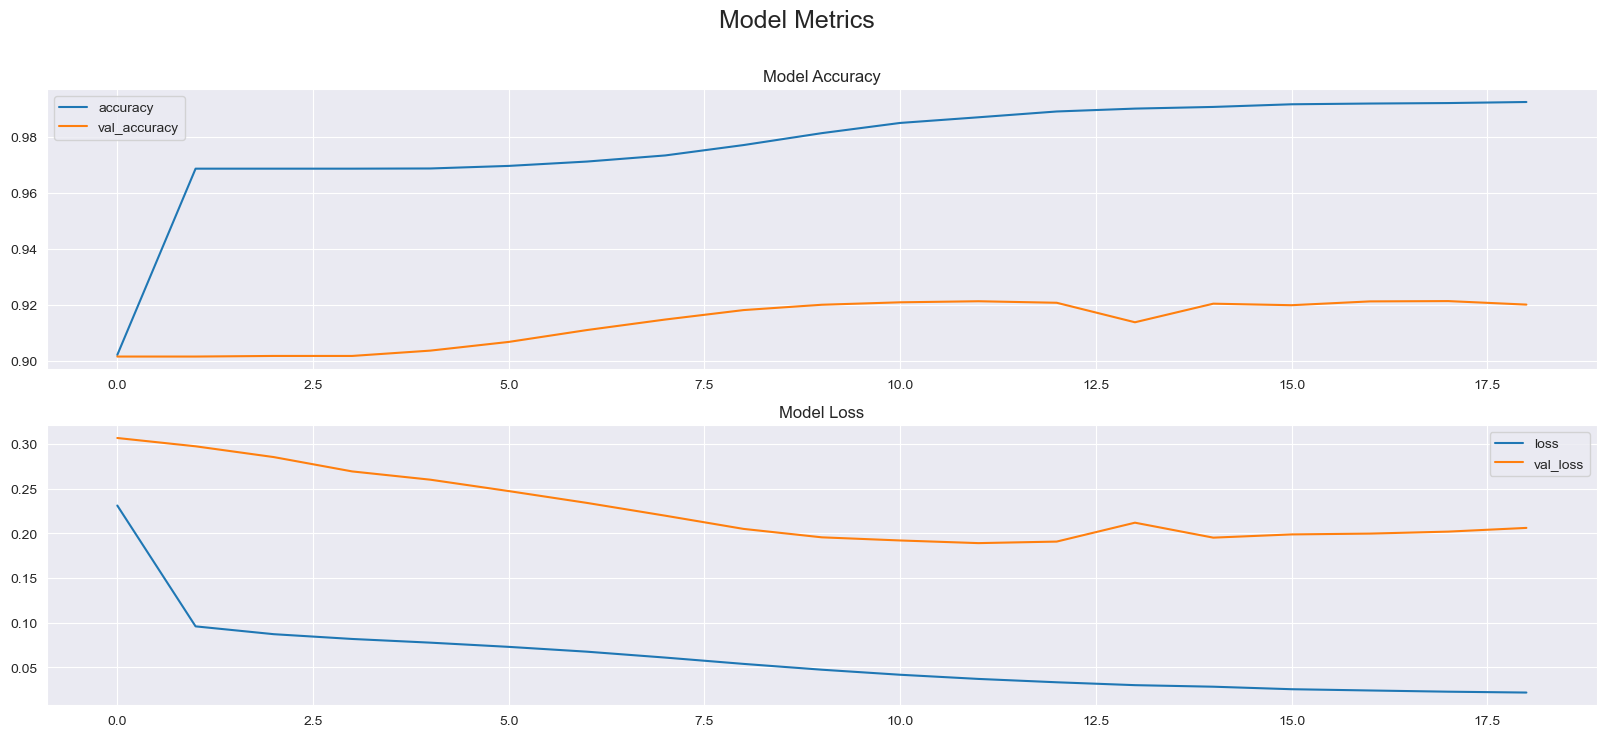

In [153]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [154]:
i = np.random.randint(0, X.shape[0])
p = model.predict(np.array([X[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(y, axis=-1)[i]

print(f"{'Word':15}\t{'Tag':5}\t{'Pred'}")
print("-"*30)
for (w, t, pred) in zip(X[i], y_true, p[0]):
    print(f"{words[w]:15}{tags[t]}\t{tags[pred]}")
    if words[w] == 'ENDPAD': 
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Word           	Tag  	Pred
------------------------------
The            O	O
parser         B	B
generates      O	O
tree           B	B
-              I	I
structured     B	I
logical        I	I
forms          I	I
with           O	O
a              O	O
transition     B	B
-              I	I
based          I	I
approach       I	I
,              O	O
combining      O	O
a              O	O
generic        B	B
tree           I	I
-              O	I
generation     B	I
algorithm      I	I
with           O	O
domain         B	O
-              O	I
general        B	O
grammar        I	I
defined        O	O
by             O	O
the            O	O
logical        B	B
language       I	I
.              O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated        O	O
negated      

prepare test data

In [174]:
test_tokens = test_df["tokens"]
test_tags = test_df["tags"]

In [175]:
import pandas as pd

def create_sentence_word_tag_pairs(tags_df, tokens_df):
  sentences = []
  for i in range(len(tags_df)):
    tag_list = tags_df.iloc[i]
    token_list = tokens_df.iloc[i]
    sentence = list(zip(token_list, tag_list))
    sentences.append(sentence)
  return sentences

# Assuming your data is in pandas DataFrames named 'test_tags' and 'test_tokens'

# Create the list of sentences
test_sentences = create_sentence_word_tag_pairs(test_tags, test_tokens)

print(test_sentences[:2]) # Print the first two sentences

[[('Systems', 'O'), ('based', 'O'), ('on', 'O'), ('synchronous', 'B'), ('grammars', 'I'), ('and', 'O'), ('tree', 'B'), ('transducers', 'B'), ('promise', 'O'), ('to', 'O'), ('improve', 'O'), ('the', 'O'), ('quality', 'O'), ('of', 'O'), ('statistical', 'B'), ('machine', 'I'), ('translation', 'I'), ('output', 'I'), (',', 'O'), ('but', 'O'), ('are', 'O'), ('often', 'O'), ('very', 'O'), ('computationally', 'B'), ('intensive', 'O'), ('.', 'O')], [('The', 'O'), ('complexity', 'B'), ('is', 'O'), ('exponential', 'B'), ('in', 'O'), ('the', 'O'), ('size', 'O'), ('of', 'O'), ('individual', 'O'), ('grammar', 'B'), ('rules', 'I'), ('due', 'O'), ('to', 'O'), ('arbitrary', 'B'), ('re', 'O'), ('orderings', 'O'), ('between', 'O'), ('the', 'O'), ('two', 'O'), ('languages', 'O'), ('.', 'O')]]


In [176]:
import pandas as pd

def extract_words_from_dataframe(df):
  all_words = []
  for sentence in df['tokens']:  # Assuming the column name is 'tokens'
    all_words.extend(sentence)
  return all_words

def find_unique_words(words):
  return list(set(words))

# Assuming your DataFrame is named 'train_df'
all_words = extract_words_from_dataframe(test_df) 
tunique_words = find_unique_words(all_words)

print(tunique_words)

['data', 'its', 'factors', 'Hyperedge', 'expertise', 'languages', 'understudied', 'various', 'transducers', 'Specifically', 'this', 'First', 'then', ':', 'examples', 'HRG', 'partial', 'perspectives', 'surrounding', 'Information', 'posits', 'deemed', 'immediate', 'Annotation', 'preserves', 'isoglosses', 'increasingly', 'Translation', 'member', 'best', 'so', 'empirically', 'how', 'binary', 'connect', 'fact', 'incurred', 'NER', 'efficiently', 'total', 'comparative', 'defines', 'alternates', 'differences', 'preference', 'growing', 'semiring', 'We', 'Grammars', 'Linguistic', 'train', 'scales', 'shown', 'personal', 'large-scale', 'aims', 'available', 'long', 'is', 'political', 'outperforms', 'impacting', 'described', 'function', 'contrast', 'generator', 'analyze', 'influential', 'homonymy-like', 'large', 'vertex', 'estimate', 'output', 'overgeneration', 'corpus', 'nuclei', 'classifiers', 'very', 'native', 'experiment', 'into', 'fine-grained', 'help', 'correspond', 'performance', 'report', 's

In [177]:
tunique_tags = list(set(tag for tags in test_labels for tag in tags))

In [178]:
word2idxt = {w: i for i, w in enumerate(tunique_words)}
tag2idxt = {t: i for i, t in enumerate(tunique_tags)}

In [179]:
print(tunique_tags)

['O', 'B', 'I']


In [180]:
n_twords = len(tunique_words)

In [181]:
#def prepare_test_data(test_sentences, maxlen, word2idx, tag2idx, n_twords, n_tags, unk_token="<UNK>"):
def prepare_test_data(test_sentences, maxlen, word2idxt, tag2idxt, n_twords, n_tags):
  X_test = [[word2idxt.get(w[0], n_twords - 1) for w in s] for s in test_sentences]
  X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post", value=n_twords - 1)

  y_test = [[tag2idxt[w[1]] for w in s] for s in test_sentences]
  y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idxt["O"]) 
  y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

  return X_test, np.array(y_test)

plot confusion

In [182]:
from tensorflow.keras.models import load_model

model=load_model('model.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Classification Report:
               precision    recall  f1-score   support

           B       0.08      0.16      0.11       434
           I       0.10      0.21      0.14       463
           O       0.97      0.93      0.95     20763

    accuracy                           0.90     21660
   macro avg       0.39      0.43      0.40     21660
weighted avg       0.94      0.90      0.92     21660



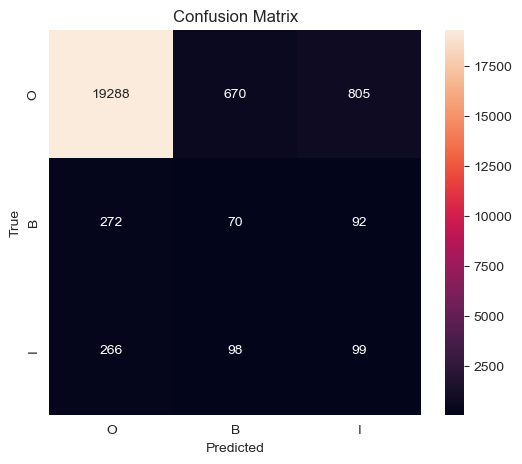

In [185]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, X_test, y_test, tag2idxt):

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=-1)

    # Flatten true and predicted labels
    y_true_flat = np.argmax(y_test, axis=-1).flatten() 
    y_pred_flat = y_pred_classes.flatten()

    # Remove padding indices (assuming 0 is the padding index for tags)
    #mask = y_true_flat != tag2idx["O"]
    #y_true_flat = y_true_flat[mask]
    #y_pred_flat = y_pred_flat[mask]

    # Convert indices back to tags
    idx2tag = {v: k for k, v in tag2idxt.items()} 
    y_true_tags = [idx2tag[i] for i in y_true_flat]
    y_pred_tags = [idx2tag[i] for i in y_pred_flat]

    # Generate classification report
    report = classification_report(y_true_tags, y_pred_tags)
    print("\nClassification Report:\n", report)

    # Generate and plot confusion matrix
    conf_matrix = confusion_matrix(y_true_tags, y_pred_tags, labels=list(tag2idxt.keys()))
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=list(tag2idxt.keys()), yticklabels=list(tag2idxt.keys()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
X_test, y_test = prepare_test_data(test_sentences, maxlen, word2idxt, tag2idxt, n_twords, n_tags)
evaluate_model(model, X_test, y_test, tag2idxt)



In [171]:
# save the model
import joblib
joblib.dump(model, 'model.pkl')


['model.pkl']

In [165]:
def predict_sentence(sentence, model, word2idx, tag2idx, maxlen):
    """
    Predicts the NER tags for a given sentence.

    Args:
        sentence: The input sentence (string).
        model: The trained Keras model.
        word2idx: Dictionary mapping words to their indices.
        tag2idx: Dictionary mapping tags to their indices.
        maxlen: Maximum sequence length for padding.

    Returns:
        A list of predicted tags for the sentence.
    """

    # Ensure <UNK> and <PAD> are in word2idx
    if "<UNK>" not in word2idx:
        word2idx["<UNK>"] = len(word2idx)
    if "<PAD>" not in word2idx:
        word2idx["<PAD>"] = len(word2idx)

    # Tokenize the sentence
    words = sentence.split()

    # Convert words to indices
    X_test = [[word2idx.get(w, word2idx["<UNK>"]) for w in words]]

    # Pad the sequence
    X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post", value=word2idx["<PAD>"])

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=-1)[0]  # Get predictions for the first (and only) sentence

    # Convert predicted indices to tags
    idx2tag = {v: k for k, v in tag2idx.items()}
    predicted_tags = [idx2tag[i] for i in y_pred_classes]

    return predicted_tags

# Example usage:

sentence = "i live NLP in Machine Learning"
predicted_tags = predict_sentence(sentence, model, word2idx, tag2idx, maxlen)

print("Sentence:", sentence)
print("Predicted Tags:", predicted_tags)

InvalidArgumentError: Graph execution error:

Detected at node sequential_7_1/embedding_7_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Cs-Store\anaconda3\Lib\asyncio\windows_events.py", line 322, in run_forever

  File "c:\Users\Cs-Store\anaconda3\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\Cs-Store\anaconda3\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "c:\Users\Cs-Store\anaconda3\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Cs-Store\AppData\Local\Temp\ipykernel_47848\2313473496.py", line 2, in <module>

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 559, in predict

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 256, in one_step_on_data_distributed

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 246, in one_step_on_data

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 101, in predict_step

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 632, in call

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py", line 140, in call

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\ops\numpy.py", line 5239, in take

  File "c:\Users\Cs-Store\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2063, in take

indices[0,1] = 4002 is not in [0, 4002)
	 [[{{node sequential_7_1/embedding_7_1/GatherV2}}]] [Op:__inference_one_step_on_data_distributed_198921]